In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

np.random.seed(0)

import torch

world_number = 1
length = 3

import os
# which folder
folder = f"world_{world_number}/length_{length}"
# Function to get the next available filename


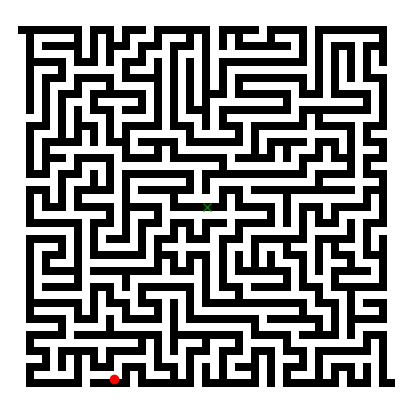

In [2]:
from maze_env import Maze
env = Maze(sparse=True)
env.plot()

The shape of the sequence_pairs are: 
torch.Size([100000, 2, 3, 2])
Example of a sequence_pair: tensor([[[ 9., 23.],
         [10., 23.],
         [11., 23.]],

        [[12., 17.],
         [13., 17.],
         [14., 17.]]])

The shape of the preferences are: 
torch.Size([100000, 1])
The preferences are: tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])


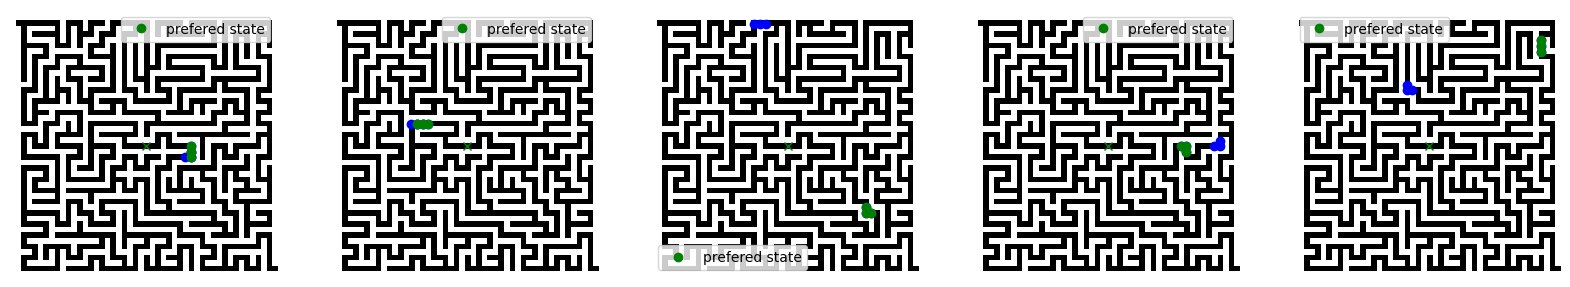

In [3]:
# load the sequence_pairs and preferences.pt
sequence_pairs = torch.load(f'{folder}/sequence_pairs.pt')
preferences = torch.load(f'{folder}/preferences.pt')

print("The shape of the sequence_pairs are: \n" + str(sequence_pairs.size()))
print("Example of a sequence_pair: " + str(sequence_pairs[0]))
print("")
print("The shape of the preferences are: \n" + str(preferences.size()))
print("The preferences are: " + str(preferences))

num_pairs = sequence_pairs.size()[0]
# select 5 random pairs of states, and colour the state that is prefered in green
num_plot = 5
# create subplots
fig, axs = plt.subplots(1, num_plot, figsize=(20,5))
# plot each sequence_pair
for i in range(num_plot):
    # randomly choose a sequence_pair
    idx = np.random.randint(num_pairs)
    s1 = sequence_pairs[idx,0,:]
    s2 = sequence_pairs[idx,1,:]
    p = preferences[idx,0]
    # plot the first state
    axs[i].imshow(env.occ_map.T, origin="lower",extent=[0,env.Nx,0,env.Ny], cmap='gray')
    axs[i].plot(env.gx+0.5,env.gy+0.5,'gx') # goal location
    axs[i].plot(s1[:,0]+0.5,s1[:,1]+0.5,'bo')
    # plot the second state
    axs[i].plot(s2[:,0]+0.5,s2[:,1]+0.5,'bo')
    # plot the prefered state in green
    if p == 0:
        axs[i].plot(s1[:,0]+0.5,s1[:,1]+0.5,'go', label='prefered state')
    else:
        axs[i].plot(s2[:,0]+0.5,s2[:,1]+0.5,'go', label='prefered state')
    # finish up the rest of the plot settings
    axs[i].legend()
    axs[i].axis('off')

In [4]:
# create dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

class PreferenceDataset(Dataset):
    def __init__(self, sequence_pairs, preferences):
        self.sequence_pairs = sequence_pairs
        self.preferences = preferences

    def __getitem__(self, index):
        return self.sequence_pairs[index], self.preferences[index]

    def __len__(self):
        return len(self.sequence_pairs)

In [5]:
dataset = PreferenceDataset(sequence_pairs, preferences)
# split the dataset into train, validation and test
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
# create dataloaders
batch_size = 1000
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

# print the shapes of batches from dataloaders
batch = next(iter(train_loader))
print("The shape of the input batch: " + str(batch[0].shape))
print("The shape of the batch labels: " + str(batch[1].shape))

The shape of the input batch: torch.Size([1000, 2, 3, 2])
The shape of the batch labels: torch.Size([1000, 1])


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

# create a preference learning model
from maze_PTR_model import MazePTRModel
    
# training step
def training_step(input_batch, target_batch, model, optimizer, loss_fn):
    preds = model(input_batch) # forward pass
    loss = loss_fn(preds, target_batch) # find loss
    optimizer.zero_grad() # clear gradients in the optimiser
    loss.backward() # back prop
    optimizer.step() # gradient descend
    return loss.item() # return loss

# validation step
def validation_step(input_batch, target_batch, model, loss_fn):
    preds = model(input_batch) # forward pass
    loss = loss_fn(preds, target_batch) # find loss
    return loss.item()

In [7]:
# instantiate
model = MazePTRModel()

print(model)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

def loss_fn(preds, target):
    return F.binary_cross_entropy(preds, target)

num_epochs = 20

MazePTRModel(
  (fc): Sequential(
    (0): Linear(in_features=96, out_features=800, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=800, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=400, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
  (relu): LeakyReLU(negative_slope=0.01)
)


In [8]:
# if the models folder doesn't exist, create one
if not os.path.exists(f'{folder}/models'):
    os.makedirs(f'{folder}/models')
#base_filename = f'{folder}/models/best_model'
#file_extension = 'pt'
#next_filename = get_next_filename(base_filename, file_extension)
best_model_filename = f'{folder}/models/best_model.pt'
last_model_filename = f'{folder}/models/last_model.pt'

# train
train_losses = []
val_losses = []
min_val_loss = float('inf')
early_stop_counter = 0
patience = 10

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    # training
    model.train()
    for input_batch, target_batch in train_loader:
        train_loss += training_step(input_batch, target_batch, model, optimizer, loss_fn)
    # validation
    model.eval()
    for input_batch, target_batch in val_loader:
        val_loss += validation_step(input_batch, target_batch, model, loss_fn)
        
    # normalise the losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    # Check if validation loss has decreased
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        # Save the model state
        torch.save(model.state_dict(), best_model_filename)
        # clear early stop counter
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    torch.save(model.state_dict(), last_model_filename)
    # append the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # print the losses every 10 epoch
    #if epoch % 10 == 0:
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch: 1/20, Train Loss: 0.6612, Val Loss: 0.6353
Epoch: 2/20, Train Loss: 0.6087, Val Loss: 0.5817
Epoch: 3/20, Train Loss: 0.5547, Val Loss: 0.5299
Epoch: 4/20, Train Loss: 0.5071, Val Loss: 0.4887
Epoch: 5/20, Train Loss: 0.4708, Val Loss: 0.4582
Epoch: 6/20, Train Loss: 0.4437, Val Loss: 0.4350
Epoch: 7/20, Train Loss: 0.4224, Val Loss: 0.4163
Epoch: 8/20, Train Loss: 0.4047, Val Loss: 0.4003
Epoch: 9/20, Train Loss: 0.3891, Val Loss: 0.3860
Epoch: 10/20, Train Loss: 0.3750, Val Loss: 0.3728
Epoch: 11/20, Train Loss: 0.3621, Val Loss: 0.3607
Epoch: 12/20, Train Loss: 0.3501, Val Loss: 0.3495
Epoch: 13/20, Train Loss: 0.3391, Val Loss: 0.3390
Epoch: 14/20, Train Loss: 0.3288, Val Loss: 0.3294
Epoch: 15/20, Train Loss: 0.3194, Val Loss: 0.3204
Epoch: 16/20, Train Loss: 0.3106, Val Loss: 0.3121
Epoch: 17/20, Train Loss: 0.3025, Val Loss: 0.3044
Epoch: 18/20, Train Loss: 0.2950, Val Loss: 0.2972
Epoch: 19/20, Train Loss: 0.2880, Val Loss: 0.2905
Epoch: 20/20, Train Loss: 0.2814, Val Lo

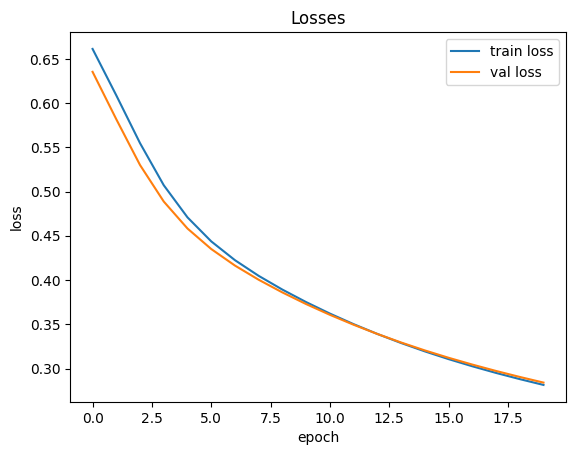

In [9]:

loss_filename = f'{folder}/models/loss.png'

# plot the losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')  
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()
plt.savefig(loss_filename)
plt.show()

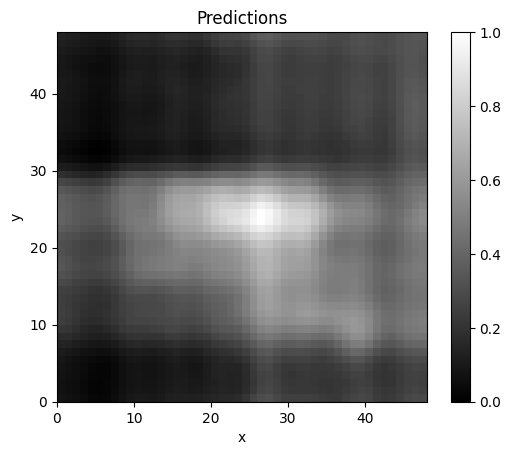

In [10]:
# plot the predictions over a 2D grid 
def plot_predictions(model, env):
    # create a 2D grid
    x = np.linspace(0, env.Nx-1, env.Nx)
    y = np.linspace(0, env.Ny-1, env.Ny)
    Y, X = np.meshgrid(x, y)
    
    # create a tensor of the grid
    grid = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float)
    # get the predictions
    time_proximity_to_goal = model.predict_time_to_goal(grid).detach().numpy()
    # reshape the predictions
    time_proximity_to_goal = time_proximity_to_goal.reshape(env.Nx, env.Ny)
    #rewards = np.exp(-1*time_proximity_to_goal)
    time_proximity_to_goal = (time_proximity_to_goal - np.min(time_proximity_to_goal))/(np.max(time_proximity_to_goal) - np.min(time_proximity_to_goal))
    rewards = 1 - time_proximity_to_goal
    # plot the predictions
    plt.imshow(rewards.T, origin="lower",extent=[0,env.Nx,0,env.Ny], cmap='gray')
    plt.colorbar()
    #plt.plot(env.gx+0.5,env.gy+0.5,'gx') # goal location
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Predictions')
    plt.savefig(f'{folder}/models/predictions.png')
    plt.show()
model.eval()
plot_predictions(model, env)